In [2]:
!pip install hmmlearn
import numpy as np
import pandas as pd
!pip install mca
import mca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
!pip install -U scikit-fuzzy
import skfuzzy as fuzz
from hmmlearn import hmm
import seaborn as sns
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mca: filename=mca-1.0.3-py2.py3-none-any.whl size=6009 sha256=6de762dec40e1b8a338ad023e0ded8b7ead408f6c575378db92a2bc666f12fc8
  Stored in directory: /root/.cache/pip/wheels/41/3c/28/32383be9777008d3318b6e787b89273ca4a6c6c915ce9bd1f3
Successfully built mca
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.9 MB/s eta 0:00:00


<ipython-input-4-4b29cbb961b2>:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_all_years['Polypharmacy'] = (data_all_years[medication_cols].sum(axis=1) >= 5).astype(int)
<ipython-input-4-4b29cbb961b2>:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_all_years['Multimorbidity'] = (data_all_years[disease_cols].sum(axis=1) >= 2).astype(int)
<ipython-input-4-4b29cbb961b2>:110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

     ID  Year        Age     Sex Socioeconomic_Status  Creatinine  Disease_1  \
0     1     1  70.766334    Male                    1    1.724727          0   
1     2     1  86.180356    Male                    3    1.046533          0   
2     3     1  80.894041    Male                    5    1.116122          1   
3     4     1  67.653419  Female                    5    1.346419          0   
4     5     1  74.518358  Female                    2    1.508921          0   
..   ..   ...        ...     ...                  ...         ...        ...   
245  46     5  79.621976  Female                    1    1.080221          0   
246  47     5  69.955535    Male                    2    0.929821          1   
247  48     5  74.830515    Male                    4    0.701636          1   
248  49     5  75.174180  Female                    3    1.020809          1   
249  50     5  75.754237    Male                    3    1.049550          0   

     Disease_2  Disease_3  Disease_4  .


         5    -385.22437405      +3.17808166
         6    -383.15810517      +2.06626889
         7    -379.87632007      +3.28178510
         8    -377.58705031      +2.28926975
         9    -376.38771336      +1.19933696
        10    -375.47271146      +0.91500190
        11    -374.90706752      +0.56564394
        12    -374.54303678      +0.36403074
        13    -374.29637013      +0.24666664
        14    -374.23385029      +0.06251984
        15    -374.22840946      +0.00544083


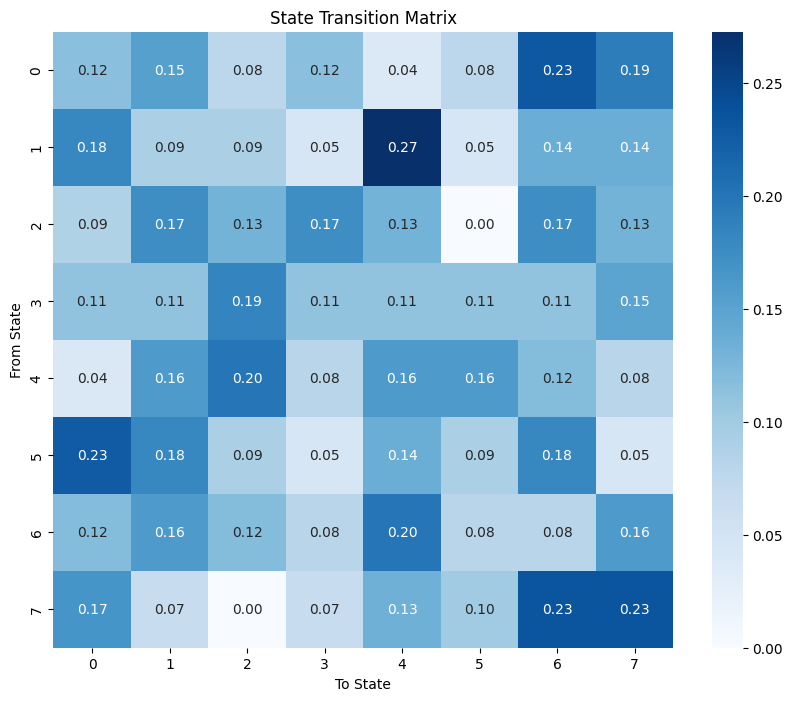

In [4]:
# Set seed for reproducibility
np.random.seed(123)

# Number of individuals and time points
n_individuals = 50
n_years = 5

# Initialize an empty list to store data for each year
data_list = []

for year in range(1, n_years + 1):
    # Simulate demographics
    age = np.random.normal(loc=78.8, scale=7.4, size=n_individuals)
    age = np.clip(age, 65, 99)

    sex = np.random.choice(['Male', 'Female'], size=n_individuals, p=[0.596, 0.404])

    socioeconomic_status = np.random.choice([1, 2, 3, 4, 5], size=n_individuals)

    # Simulate diseases
    disease_prevalence = np.random.uniform(0.02, 0.50, size=41)
    diseases = np.array([np.random.binomial(1, p, n_individuals) for p in disease_prevalence]).T
    disease_cols = [f'Disease_{i+1}' for i in range(41)]

    # Adjust disease prevalence due to on age
    prob = 1 / (1 + np.exp(-(-5 + 0.05 * age)))
    diseases = np.array([np.random.binomial(1, p) for p in prob]).reshape(-1, 1) * np.ones((1, 41))

    # Simulate medications
    medication_prevalence = np.random.uniform(0.01, 0.50, size=89)
    medications = np.array([np.random.binomial(1, p, n_individuals) for p in medication_prevalence]).T
    medication_cols = [f'Medication_{i+1}' for i in range(89)]

    # Adjust medication due to disease
    for i in range(89):
        medication_name = medication_cols[i]
        associated_disease = np.random.choice(disease_cols)
        prob = np.where(diseases[:, disease_cols.index(associated_disease)] == 1, 0.7, 0.1)
        medications[:, i] = np.random.binomial(1, prob)

    # Simulate lab results
    creatinine = np.random.normal(loc=1, scale=0.3, size=n_individuals)

    # Combine all data
    data_year = pd.DataFrame({
        'ID': np.arange(1, n_individuals + 1),
        'Year': year,
        'Age': age,
        'Sex': sex,
        'Socioeconomic_Status': socioeconomic_status,
        'Creatinine': creatinine
    })

    diseases_df = pd.DataFrame(diseases, columns=disease_cols)
    medications_df = pd.DataFrame(medications, columns=medication_cols)

    data_year = pd.concat([data_year, diseases_df, medications_df], axis=1)

    data_list.append(data_year)

# Combine data for all years
data_all_years = pd.concat(data_list, ignore_index=True)

# Data
data_all_years['Sex'] = data_all_years['Sex'].astype('category')
data_all_years['Socioeconomic_Status'] = data_all_years['Socioeconomic_Status'].astype('category')

disease_cols = [col for col in data_all_years.columns if 'Disease_' in col]
medication_cols = [col for col in data_all_years.columns if 'Medication_' in col]

data_all_years[disease_cols] = data_all_years[disease_cols].astype(int)
data_all_years[medication_cols] = data_all_years[medication_cols].astype(int)

# Calculate polypharmacy and multimorbidity
data_all_years['Polypharmacy'] = (data_all_years[medication_cols].sum(axis=1) >= 5).astype(int)
data_all_years['Multimorbidity'] = (data_all_years[disease_cols].sum(axis=1) >= 2).astype(int)

# Dimensionality reduction using mca
categorical_vars = disease_cols + medication_cols + ['Sex', 'Socioeconomic_Status']

data_categorical = pd.get_dummies(data_all_years[categorical_vars],
                                 columns=categorical_vars,
                                 drop_first=True)

# Perform MCA
mca_ben = mca.MCA(data_categorical)

# Get MCA components
mca_components = pd.DataFrame(mca_ben.fs_r(N=5), columns=[f'MCA_{i+1}' for i in range(5)])

# Perform PCA on continuous variables
continuous_vars = ['Age', 'Creatinine']
scaler = StandardScaler()
scaled_continuous = scaler.fit_transform(data_all_years[continuous_vars])

pca = PCA(n_components=2, random_state=123)
pca_components = pca.fit_transform(scaled_continuous)

# Combine components
combined_components = pd.concat([pd.DataFrame(pca_components, columns=['PCA_1', 'PCA_2']), mca_components.reset_index(drop=True)], axis=1)

# Fuzzy c-means clustering
data_array = combined_components.values.T
n_clusters = 8

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_array, n_clusters, m=2, error=0.005, maxiter=1000, init=None, seed=123)

cluster_labels = np.argmax(u, axis=0)
data_all_years['Cluster'] = cluster_labels

print(data_all_years)

# Hidden Markov Model
data_all_years.sort_values(by=['ID', 'Year'], inplace=True)
cluster_pivot = data_all_years.pivot(index='ID', columns='Year', values='Cluster')
cluster_pivot.dropna(inplace=True)
X = cluster_pivot.values.astype(int)

model = hmm.MultinomialHMM(n_components=n_clusters, n_iter=100, random_state=123, verbose=True)
model.fit(X)
hidden_states = model.predict(X)

hidden_states_expanded = np.repeat(hidden_states, n_years)
data_all_years = data_all_years[data_all_years['ID'].isin(cluster_pivot.index)]
data_all_years['State'] = hidden_states_expanded


# Results
state_grouped = data_all_years.groupby('State')
state_prevalence = state_grouped[disease_cols + medication_cols].mean()
overall_prevalence = data_all_years[disease_cols + medication_cols].mean()

O_E_ratio = state_prevalence.div(overall_prevalence)
state_sizes = state_grouped.size()
total_counts = data_all_years[disease_cols + medication_cols].sum()

exclusivity = (state_prevalence.mul(state_sizes, axis=0)).div(total_counts)



# Visualizations
demographics = state_grouped['Age'].mean()
sex_distribution = state_grouped['Sex'].value_counts(normalize=True).unstack()

print("Average Age by State:")
print(demographics)
print("\nSex Distribution by State:")
print(sex_distribution)

# Transition matrix
transitions = np.zeros((n_clusters, n_clusters))

for i in range(X.shape[0]):
    for t in range(n_years - 1):
        transitions[X[i, t], X[i, t + 1]] += 1

transition_matrix = transitions / transitions.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.title('State Transition Matrix')
plt.xlabel('To State')
plt.ylabel('From State')
plt.show()
